# 목표
**Movielens 1M Dataset을 기반으로, Session based Recommendation 시스템을 제작해보기**

- 데이터셋에 명확한 1회 세션의 SessionID를 포함하지 않고있다.
- UserID가 SessionID 역할을 하게된다.
- Rating 정보가 포함되어 있다. 
- Rating이 낮은 데이터를 어떻게 처리할지를 고민해야한다.
- Time 항목에는 UTC time이 포함되어있으며 1970-01-01 ~ 경과된 초 단위 시간이 기재되어있다.

## Movielens 기반 Session-based Recommendation 프로젝트 요약

### 1. 세션 기반 전처리 및 세션 정의

Movielens 1M 데이터셋을 기반으로, Session-ID가 따로 없는 구조를 고려해 `UserId`를 세션 단위처럼 활용했습니다.  
Rating이 3점 이상인 데이터만 남기고, Time 컬럼을 datetime 형식으로 변환해 **사용자의 행동 흐름을 시간 순서대로 정렬**했습니다.  
또한, 클릭 수가 적거나 너무 짧은 세션은 제거하여 학습에 방해되는 노이즈를 최소화했습니다.  
최종적으로는 `split_by_date()`를 활용해 **최근 7일 데이터를 validation/test로 분리**해 시간 기반 흐름도 유지하도록 구성했습니다.

---

### 2. RNN 기반 모델 구성 및 학습 과정

GRU 기반의 시퀀스 모델을 사용했으며, 구조는 `GRU → Dropout → Dense(Softmax)` 형태로 구성했습니다.  
학습은 `train_model()` 함수에서 에포크 단위로 loss, recall@k, mrr@k를 기록할 수 있도록 리팩토링해 진행했습니다.  
또한 세션이 종료될 때마다 GRU의 hidden state를 초기화하여 세션 단위로 독립적인 학습이 가능하도록 조정했습니다.    
에폭을 증가시켜서 train loss 과정을 보았을때 에폭 3 부터는 많은 변화가 없다는것을 반복적으로 하면서 알게되었습니다.

---

### 3. 실험적 변경과 성능 분석

다양한 조건을 바꿔가며 실험을 진행했습니다.  
- **batch_size 변경** (256 → 128 → 256): 메모리 상황과 성능 변화 관찰  
- **epochs 증가** (3 → 10): 학습 안정성과 수렴 정도 비교  
- **데이터 전처리 조건 변화** (shortest, least_click 등): 훈련 데이터 품질에 따른 성능 변화 확인  

각 실험 후 `Recall@20`, `MRR@20` 지표를 기록하며 결과를 비교했고, 일부 개선이 확인되었지만 **수치가 드라마틱하게 상승하지는 않아 아쉬움도 남았습니다.**    
**맨 아래 하단 지표를 바꾸어가며 실험한 기록이 있습니다.**

---

### 개인적인 느낀 점

전처리부터 모델 구성, 학습, 평가까지 직접 하나씩 코드를 작성해보며 추천 시스템이 조정이 필요한지 체감할 수 있었고,  
단순히 수치를 높이는 게 아닌 **데이터의 흐름과 의미를 이해하는 것이 얼마나 중요한지도 다시 느꼈습니다.**  
실험을 거듭하며 수치가 조금씩 개선되는 과정을 보는 건 흥미로웠지만, **드라마틱한 성능 향상을 보지 못한 부분은 살짝 아쉬움으로 남습니다.**  
그럼에도 이 과정을 통해 추천 시스템 전반에 대한 이해가 깊어진 경험이었습니다.

In [1]:
# 라이브러리 버전 확인
import pandas
import tensorflow

print(pandas.__version__)
print(tensorflow.__version__)

1.3.3
2.6.0


In [2]:
# 라이브러리 불러오기

import datetime as dt
from pathlib import Path
import os
import time
from datetime import datetime
from IPython.display import display

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

In [3]:
data_path = Path(os.getenv('HOME')+'/aiffel/yoochoose/data/') 
train_path = data_path / 'ratings.dat'

def load_data(data_path: Path, nrows=None):
    data = pd.read_csv(data_path, sep='::', header=None, usecols=[0, 1, 2, 3], dtype={0: np.int32, 1: np.int32, 2: np.int32}, nrows=nrows)
    data.columns = ['UserId', 'ItemId', 'Rating', 'Time']
    # time 형식을 기존과 맞게 고쳐보기
    data['Time'] = pd.to_datetime(data['Time'], unit='s')
    return data

data = load_data(train_path, None)
data.sort_values(['UserId', 'Time'], inplace=True)  # data를 id와 시간 순서로 정렬해줍니다.
data

,UserId,ItemId,Rating,Time
31,1,3186,4,2000-12-31 22:00:19
22,1,1270,5,2000-12-31 22:00:55
27,1,1721,4,2000-12-31 22:00:55
37,1,1022,5,2000-12-31 22:00:55
24,1,2340,3,2000-12-31 22:01:43
...,...,...,...,...
1000019,6040,2917,4,2001-08-10 14:40:29
999988,6040,1921,4,2001-08-10 14:41:04
1000172,6040,1784,3,2001-08-10 14:41:04
1000167,6040,161,3,2001-08-10 14:41:26


# Step 1. 데이터의 전처리

In [4]:
# short_session을 제거한 다음 unpopular item을 제거하면 다시 길이가 1인 session이 생길 수 있습니다.
# 이를 위해 반복문을 통해 지속적으로 제거 합니다.

def load_data(data_path: Path, nrows=None):
    data = pd.read_csv(
        data_path,
        sep='::',
        header=None,
        usecols=[0, 1, 2, 3],
        dtype={0: np.int32, 1: np.int32, 2: np.int32},
        nrows=nrows,
        engine='python'
    )
    data.columns = ['UserId', 'ItemId', 'Rating', 'Time']

    # 평점 3 이상 필터링
    data = data[data['Rating'] >= 3]

    # Time 컬럼 변환
    data['Time'] = pd.to_datetime(data['Time'], unit='s')

    return data

def cleanse_recursive(data: pd.DataFrame, shortest, least_click) -> pd.DataFrame:
    while True:
        before_len = len(data)
        data = cleanse_short_session(data, shortest)
        data = cleanse_unpopular_item(data, least_click)
        after_len = len(data)
        if before_len == after_len:
            break
    return data


def cleanse_short_session(data: pd.DataFrame, shortest):
    session_len = data.groupby('UserId').size()
    session_use = session_len[session_len >= shortest].index
    data = data[data['UserId'].isin(session_use)]
    return data


def cleanse_unpopular_item(data: pd.DataFrame, least_click):
    item_popular = data.groupby('ItemId').size()
    item_use = item_popular[item_popular >= least_click].index
    data = data[data['ItemId'].isin(item_use)]
    return data

In [5]:
import datetime as dt

# 세션 기준 날짜 분할 함수 정의
def split_by_date(data: pd.DataFrame, n_days: int):
    final_time = data['Time'].max()
    session_last_time = data.groupby('UserId')['Time'].max()
    
    session_in_train = session_last_time[session_last_time < final_time - dt.timedelta(days=n_days)].index
    session_in_test = session_last_time[session_last_time >= final_time - dt.timedelta(days=n_days)].index

    before = data[data['UserId'].isin(session_in_train)]
    after = data[data['UserId'].isin(session_in_test)]
    after = after[after['ItemId'].isin(before['ItemId'])]  # unseen 아이템 제거
    return before, after

# Train / Validation / Test 분할
train_temp, test = split_by_date(data, n_days=7)
tr, val = split_by_date(train_temp, n_days=7)

In [6]:
# validation/test 에서 train에 없는 아이템 제거
val = val[val['ItemId'].isin(tr['ItemId'])]
test = test[test['ItemId'].isin(tr['ItemId'])]

In [7]:
data = load_data(train_path)
data.sort_values(['UserId', 'Time'], inplace=True)

# ID 리맵핑
item2idx = {item: idx for idx, item in enumerate(data['ItemId'].unique())}
user2idx = {user: idx for idx, user in enumerate(data['UserId'].unique())}
data['ItemId'] = data['ItemId'].map(item2idx)
data['UserId'] = data['UserId'].map(user2idx)

In [8]:
# 호출 추가 (전처리 기준 강화 (shortest=2, least_click=5) -> (hortest=3, least_click=10) )
data = cleanse_recursive(data, shortest=3, least_click=10)
data

,UserId,ItemId,Rating,Time
31,0,0,4,2000-12-31 22:00:19
22,0,1,5,2000-12-31 22:00:55
27,0,2,4,2000-12-31 22:00:55
37,0,3,5,2000-12-31 22:00:55
24,0,4,3,2000-12-31 22:01:43
...,...,...,...,...
1000019,6038,1104,4,2001-08-10 14:40:29
999988,6038,315,4,2001-08-10 14:41:04
1000172,6038,87,3,2001-08-10 14:41:04
1000167,6038,410,3,2001-08-10 14:41:26


In [9]:
# 1) 세션 길이 분포 확인
print("검증 세션 수:", data['UserId'].nunique())
print("세션별 길이(상위 10개):")
print(data.groupby('UserId').size().sort_values(ascending=False).head(10))

# 2) 길이 1인 세션 개수
print("길이 1 세션 비율:",
      (data.groupby('UserId').size() == 1).mean())

검증 세션 수: 6038
세션별 길이(상위 10개):
UserId
4167    1882
4275    1692
1679    1483
1014    1141
3616    1137
5829    1134
2908    1115
1940    1105
423     1101
1979    1050
dtype: int64
길이 1 세션 비율: 0.0


In [10]:
# ItemId와 UserId를 0부터 시작하는 정수로 리맵핑

item2idx = {item: idx for idx, item in enumerate(data['ItemId'].unique())}
user2idx = {user: idx for idx, user in enumerate(data['UserId'].unique())}
data['ItemId'] = data['ItemId'].map(item2idx)
data['UserId'] = data['UserId'].map(user2idx)

In [11]:
def split_by_date(data: pd.DataFrame, n_days: int):
    final_time = data['Time'].max()
    cutoff_time = final_time - dt.timedelta(days=n_days)

    # Train: cutoff 이전의 데이터
    train = data[data['Time'] < cutoff_time]

    # Test: cutoff 이후의 데이터, 단 아이템은 train에 있던 것만
    test = data[(data['Time'] >= cutoff_time) & (data['ItemId'].isin(train['ItemId']))]

    return train, test

In [12]:
tr, test = split_by_date(data, n_days=14)  # 마지막 이틀만 테스트용으로 분리
tr, val = split_by_date(tr, n_days=14)  # 마지막 이틀만 테스트용으로 분리

In [13]:
# data에 대한 정보를 살펴봅니다.

def stats_info(data: pd.DataFrame, status: str):
    print(f'* {status} Set Stats Info\n'
          f'\t Events: {len(data)}\n'
          f'\t Sessions: {data["UserId"].nunique()}\n'
          f'\t Items: {data["ItemId"].nunique()}\n'
          f'\t First Time : {data["Time"].min()}\n'
          f'\t Last Time : {data["Time"].max()}\n')

### 클랜징 추가 진행

In [14]:
tr = cleanse_recursive(tr, shortest=2, least_click=5)
val = cleanse_recursive(val, shortest=2, least_click=1)
test = cleanse_recursive(test, shortest=2, least_click=1)

In [15]:
stats_info(tr, 'train')
stats_info(val, 'valid')
stats_info(test, 'test')

* train Set Stats Info
	 Events: 833300
	 Sessions: 6038
	 Items: 3123
	 First Time : 2000-04-25 23:05:32
	 Last Time : 2003-01-31 12:16:30

* valid Set Stats Info
	 Events: 658
	 Sessions: 32
	 Items: 540
	 First Time : 2003-01-31 17:23:06
	 Last Time : 2003-02-14 02:02:32

* test Set Stats Info
	 Events: 489
	 Sessions: 41
	 Items: 416
	 First Time : 2003-02-15 00:15:09
	 Last Time : 2003-02-28 17:49:50



In [16]:
# train set에 없는 아이템이 val, test기간에 생길 수 있으므로 train data를 기준으로 인덱싱합니다.
id2idx = {item_id : index for index, item_id in enumerate(tr['ItemId'].unique())}

def indexing(df, id2idx):
    df['item_idx'] = df['ItemId'].map(lambda x: id2idx.get(x, -1))  # id2idx에 없는 아이템은 모르는 값(-1) 처리 해줍니다.
    return df

tr = indexing(tr, id2idx)         # 학습
val = indexing(val, id2idx)    # 검증
test = indexing(test, id2idx) # 테스트

In [17]:
# 1) 세션 길이 분포 확인
print("검증 세션 수:", val['UserId'].nunique())
print("세션별 길이(상위 10개):")
print(val.groupby('UserId').size().sort_values(ascending=False).head(10))

# 2) 길이 1인 세션 개수
print("길이 1 세션 비율:",
      (val.groupby('UserId').size() == 1).mean())

검증 세션 수: 32
세션별 길이(상위 10개):
UserId
397     199
4955     80
3011     76
418      72
5651     70
5169     48
2647     12
4310     10
3730     10
194       7
dtype: int64
길이 1 세션 비율: 0.0


In [18]:
# 학습데이터 확인하기
tr

,UserId,ItemId,Rating,Time,item_idx
31,0,0,4,2000-12-31 22:00:19,0
22,0,1,5,2000-12-31 22:00:55,1
27,0,2,4,2000-12-31 22:00:55,2
37,0,3,5,2000-12-31 22:00:55,3
24,0,4,3,2000-12-31 22:01:43,4
...,...,...,...,...,...
1000019,6037,1102,4,2001-08-10 14:40:29,1102
999988,6037,314,4,2001-08-10 14:41:04,314
1000172,6037,87,3,2001-08-10 14:41:04,87
1000167,6037,409,3,2001-08-10 14:41:26,409


# Step 2. 미니 배치의 구성

In [19]:
class SessionDataset:
    """Credit to yhs-968/pyGRU4REC."""

    def __init__(self, data):
        self.df = data
        self.click_offsets = self.get_click_offsets()
        self.session_idx = np.arange(self.df['UserId'].nunique())  # indexing to SessionId

    def get_click_offsets(self):
        """
        Return the indexes of the first click of each session IDs,
        """
        offsets = np.zeros(self.df['UserId'].nunique() + 1, dtype=np.int32)
        offsets[1:] = self.df.groupby('UserId').size().cumsum()
        return offsets

In [20]:
tr_dataset = SessionDataset(tr)
tr_dataset.df.head(10)

,UserId,ItemId,Rating,Time,item_idx
31,0,0,4,2000-12-31 22:00:19,0
22,0,1,5,2000-12-31 22:00:55,1
27,0,2,4,2000-12-31 22:00:55,2
37,0,3,5,2000-12-31 22:00:55,3
24,0,4,3,2000-12-31 22:01:43,4
36,0,5,5,2000-12-31 22:02:52,5
3,0,6,4,2000-12-31 22:04:35,6
7,0,7,5,2000-12-31 22:11:59,7
47,0,8,4,2000-12-31 22:11:59,8
0,0,9,5,2000-12-31 22:12:40,9


In [21]:
tr_dataset.click_offsets

array([     0,     53,    169, ..., 832906, 833025, 833300], dtype=int32)

In [22]:
tr_dataset.session_idx

array([   0,    1,    2, ..., 6035, 6036, 6037])

In [23]:
# data 상에서 session이 시작된 위치를 가져옵니다.
start = tr_dataset.click_offsets[tr_dataset.session_idx[[[0,1,2,3]]]]      

# session이 끝난 위치 바로 다음 위치를 가져옵니다.
end = tr_dataset.click_offsets[tr_dataset.session_idx[[0,1,2,3]] + 1]  

start
end

array([ 53, 169, 215, 234], dtype=int32)

In [24]:
# 세션 길이 중 최소값에서 타겟 클릭 1개 제외한 입력 시퀀스 길이 계산

(end - start).min() -1

18

In [25]:
# 각 세션에서 21번째 위치에 있는 아이템 인덱스를 가져옵니다.

inp = tr_dataset.df['item_idx'].values[start + 20]
inp

array([ 20,  71, 173,  12])

In [26]:
# 세션별 22번째 클릭 아이템 (예측 대상) 추출

target = tr_dataset.df['item_idx'].values[start + 20 + 1]
target

array([ 21,  72, 127, 202])

In [27]:
# 함수

class SessionDataLoader:
    """Credit to yhs-968/pyGRU4REC."""


    def __init__(self, dataset: SessionDataset, batch_size=50):
        self.dataset = dataset
        
## 이부분에 batch_size 를 마지막에 남은 부분으 처리할수있게 코드 작성
#         self.batch_size = batch_size
        self.batch_size = min(batch_size, len(dataset.session_idx))  # 이 줄 추가

    def __iter__(self):
        """ Returns the iterator for producing session-parallel training mini-batches.
        Yields:
            input (B,):  Item indices that will be encoded as one-hot vectors later.
            target (B,): a Variable that stores the target item indices
            masks: Numpy array indicating the positions of the sessions to be terminated
        """

        start, end, mask, last_session, finished = self.initialize()  # initialize 메소드에서 확인해주세요.
        """
        start : Index Where Session Start
        end : Index Where Session End
        mask : indicator for the sessions to be terminated
        """

        while not finished:
            min_len = (end - start).min() - 1  # Shortest Length Among Sessions
            for i in range(min_len):
                # Build inputs & targets
                inp = self.dataset.df['item_idx'].values[start + i]
                target = self.dataset.df['item_idx'].values[start + i + 1]
                yield inp, target, mask

            start, end, mask, last_session, finished = self.update_status(start, end, min_len, last_session, finished)

    def initialize(self):
        first_iters = np.arange(self.batch_size)    # 첫 배치에 사용할 세션 Index를 가져옵니다.
        last_session = self.batch_size - 1    # 마지막으로 다루고 있는 세션 Index를 저장해둡니다.
        start = self.dataset.click_offsets[self.dataset.session_idx[first_iters]]       # data 상에서 session이 시작된 위치를 가져옵니다.
        end = self.dataset.click_offsets[self.dataset.session_idx[first_iters] + 1]  # session이 끝난 위치 바로 다음 위치를 가져옵니다.
        mask = np.array([])   # session의 모든 아이템을 다 돌은 경우 mask에 추가해줄 것입니다.
        finished = False         # data를 전부 돌았는지 기록하기 위한 변수입니다.
        return start, end, mask, last_session, finished

    def update_status(self, start: np.ndarray, end: np.ndarray, min_len: int, last_session: int, finished: bool):
        # 다음 배치 데이터를 생성하기 위해 상태를 update합니다.

        start += min_len   # __iter__에서 min_len 만큼 for문을 돌았으므로 start를 min_len 만큼 더해줍니다.
        mask = np.arange(self.batch_size)[(end - start) == 1]
        # end는 다음 세션이 시작되는 위치인데 start와 한 칸 차이난다는 것은 session이 끝났다는 뜻입니다. mask에 기록해줍니다.

        for i, idx in enumerate(mask, start=1):  # mask에 추가된 세션 개수만큼 새로운 세션을 돌것입니다.
            new_session = last_session + i
            if new_session > self.dataset.session_idx[-1]:  # 만약 새로운 세션이 마지막 세션 index보다 크다면 모든 학습데이터를 돈 것입니다.
                finished = True
                break
            # update the next starting/ending point
            start[idx] = self.dataset.click_offsets[self.dataset.session_idx[new_session]]     # 종료된 세션 대신 새로운 세션의 시작점을 기록합니다.
            end[idx] = self.dataset.click_offsets[self.dataset.session_idx[new_session] + 1]

        last_session += len(mask)  # 마지막 세션의 위치를 기록해둡니다.
        return start, end, mask, last_session, finished

In [28]:
# 학습 데이터셋에서 4개의 세션을 병렬로 처리하는 데이터로더 생성

tr_data_loader = SessionDataLoader(tr_dataset, batch_size=4)
tr_dataset.df.head(15)

,UserId,ItemId,Rating,Time,item_idx
31,0,0,4,2000-12-31 22:00:19,0
22,0,1,5,2000-12-31 22:00:55,1
27,0,2,4,2000-12-31 22:00:55,2
37,0,3,5,2000-12-31 22:00:55,3
24,0,4,3,2000-12-31 22:01:43,4
36,0,5,5,2000-12-31 22:02:52,5
3,0,6,4,2000-12-31 22:04:35,6
7,0,7,5,2000-12-31 22:11:59,7
47,0,8,4,2000-12-31 22:11:59,8
0,0,9,5,2000-12-31 22:12:40,9


In [29]:
# 데이터로더에서 첫 번째 배치를 추출
iter_ex = iter(tr_data_loader)

# 입력, 타겟, 마스크를 하나의 배치 단위로 가져옴
inputs, labels, mask = next(iter_ex)

# 모델 입력, 타겟(label), 마스크된 세션 인덱스 출력

print(f'Model Input Item Idx are : {inputs}')
print(f'Label Item Idx are : {"":5} {labels}')
print(f'Previous Masked Input Idx are {mask}')

Model Input Item Idx are : [ 0 53 64 54]
Label Item Idx are :       [ 1 54 62 24]
Previous Masked Input Idx are []


In [30]:
# 성능을 평가하는 지표 함수

# 예측 결과에 대한 MRR@k 점수 계산
def mrr_k(pred, truth: int, k: int):
    indexing = np.where(pred[:k] == truth)[0]
    if len(indexing) > 0:
        return 1 / (indexing[0] + 1)
    else:
        return 0

# 예측 결과에 대한 Recall@k 점수 계산
def recall_k(pred, truth: int, k: int) -> int:
    answer = truth in pred[:k]
    return int(answer)

In [31]:
# 필요한 라이브러리 불러오기

import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Dropout, GRU
from tensorflow.keras.losses import categorical_crossentropy
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from tqdm import tqdm

# Step 3. 모델 구성

In [32]:
# 학습을 위한 모델을 정의 함수
def create_model(args):
    inputs = Input(batch_shape=(args.batch_size, 1, args.num_items))
    gru, _ = GRU(args.hsz, stateful=True, return_state=True, name='GRU')(inputs)
    dropout = Dropout(args.drop_rate)(gru)
    predictions = Dense(args.num_items, activation='softmax')(dropout)
    model = Model(inputs=inputs, outputs=[predictions])
    model.compile(loss=categorical_crossentropy, optimizer=Adam(args.lr), metrics=['accuracy'])
    model.summary()
    return model

In [33]:
class Args:
    def __init__(self, tr, val, test, batch_size, hsz, drop_rate, lr, epochs, k):
        self.tr = tr
        self.val = val
        self.test = test
        self.num_items = tr['ItemId'].nunique()
        self.num_sessions = tr['UserId'].nunique()
        self.batch_size = batch_size
        self.hsz = hsz
        self.drop_rate = drop_rate
        self.lr = lr
        self.epochs = epochs
        self.k = k

## 배치사이즈를 너무 크게두면 밑에 평가 부분에서 nan이 나옵니다    
# args = Args(tr, val, test, batch_size=256, hsz=50, drop_rate=0.1, lr=0.001, epochs=3, k=20)

위 `epochs = 3`은 너무 낮고 성능 개선 프름을 보기 여려울것으로 판단되어,    
**epochs=10, batch_size=128, hsz=200, lr=0.0005** 정도로 늘려보기

In [47]:
# args 수정해보기
args = Args(tr, val, test, batch_size=256, hsz=200, drop_rate=0.1, lr=0.0005, epochs=10, k=20)

In [48]:
model = create_model(args)

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(256, 1, 3123)]          0         
_________________________________________________________________
GRU (GRU)                    [(256, 200), (256, 200)]  1995000   
_________________________________________________________________
dropout_2 (Dropout)          (256, 200)                0         
_________________________________________________________________
dense_2 (Dense)              (256, 3123)               627723    
Total params: 2,622,723
Trainable params: 2,622,723
Non-trainable params: 0
_________________________________________________________________


## 모델 함수를 수정 한 이유
- 기존의 train_model() 함수 문제점
   1. 에포크별 학습 손실(train loss) 로그가 남지 않음
   2. 검증 성능(Recall@k, MRR@k)을 저장하거나 시각화할 수 없음
   3. 따라서 학습이 제대로 되고 있는지, 몇 번째 에포크에서 성능이 좋아지는지 전혀 파악할 수 없었음
   
    
- 수정한 train_model() 함수는 다음과 같은 기능을 포함
   1. 에포크마다 평균 Train Loss 계산 및 저장
   2. 에포크마다 Validation Recall@k / MRR@k 평가 및 저장
   3. 학습 로그(train_losses, val_recalls, val_mrrs)를 리스트로 반환하여 이후 분석 가능
   4. 향후 그래프 시각화, Early Stopping 조건 적용 등에 유용하게 활용 가능

학습 서능이 안정적으로 수렴하는지 확인이 가능하고, 성능이 더 이상 좋아지지 않는 시점을 찾아 적절한 에포크 수 조절이 가능하다.    
학습 과정 시각화 (loss/recall/mrr)를 할 수도 있다.

In [49]:
# train 셋으로 학습하면서 valid 셋으로 검증합니다.
# 참고 : 모델 학습 코드를 수정함
def train_model(model, args):
    train_dataset = SessionDataset(args.tr)
    train_loader = SessionDataLoader(train_dataset, batch_size=args.batch_size)

    tf.config.run_functions_eagerly(True)

    # 에포크별 성능 로그 저장 리스트
    train_losses, val_recalls, val_mrrs = [], [], []

    for epoch in range(1, args.epochs + 1):
        total_step = len(args.tr) - args.tr['UserId'].nunique()
        tr_loader = tqdm(train_loader, total=total_step // args.batch_size, desc=f'Train Epoch {epoch}', mininterval=1)

        epoch_loss = []  # 이 에포크의 loss 저장용

        for feat, target, mask in tr_loader:
            reset_hidden_states(model, mask)

            input_ohe = to_categorical(feat, num_classes=args.num_items)
            input_ohe = np.expand_dims(input_ohe, axis=1)
            target_ohe = to_categorical(target, num_classes=args.num_items)

            result = model.train_on_batch(input_ohe, target_ohe)  # [loss, acc]
            epoch_loss.append(result[0])
            tr_loader.set_postfix(train_loss=result[0], accuracy=result[1])

        # 에포크 평균 loss 저장
        avg_loss = np.mean(epoch_loss)
        train_losses.append(avg_loss)

        # validation 성능 평가 및 저장
        val_recall, val_mrr = get_metrics(args.val, model, args, args.k)
        val_recalls.append(val_recall)
        val_mrrs.append(val_mrr)

        print(f"[Epoch {epoch}] Avg Train Loss: {avg_loss:.4f} | Recall@{args.k}: {val_recall:.4f} | MRR@{args.k}: {val_mrr:.4f}\n")

    # 필요하면 최종 성능 로그 반환 (선택)
    return train_losses, val_recalls, val_mrrs


def reset_hidden_states(model, mask):
    gru_layer = model.get_layer(name='GRU')  # model에서 gru layer를 가져옵니다.
    hidden_states = gru_layer.states[0].numpy()  # gru_layer의 parameter를 가져옵니다.
    for elt in mask:  # mask된 인덱스 즉, 종료된 세션의 인덱스를 돌면서
        hidden_states[elt, :] = 0  # parameter를 초기화 합니다.
    gru_layer.reset_states(states=hidden_states)


def get_metrics(data, model, args, k: int):  # valid셋과 test셋을 평가하는 코드입니다.
                                                     # train과 거의 같지만 mrr, recall을 구하는 라인이 있습니다.
    dataset = SessionDataset(data)
    loader = SessionDataLoader(dataset, batch_size=args.batch_size)
    recall_list, mrr_list = [], []

    total_step = len(data) - data['UserId'].nunique()

    for inputs, label, mask in tqdm(loader, total=total_step // args.batch_size, desc='Evaluation', mininterval=1):
        reset_hidden_states(model, mask)
        input_ohe = to_categorical(inputs, num_classes=args.num_items)
        input_ohe = np.expand_dims(input_ohe, axis=1) 
        # 
        if input_ohe.shape[0] < args.batch_size:
            pad_len = args.batch_size - input_ohe.shape[0]
            padding = np.zeros((pad_len, 1, args.num_items))
            input_ohe = np.concatenate([input_ohe, padding], axis=0)

        pred = model.predict(input_ohe, batch_size=args.batch_size)


        pred_arg = tf.argsort(pred, direction='DESCENDING')  # softmax 값이 큰 순서대로 sorting 합니다.

        length = len(inputs)
        recall_list.extend([recall_k(pred_arg[i], label[i], k) for i in range(length)])
        mrr_list.extend([mrr_k(pred_arg[i], label[i], k) for i in range(length)])
    
    
    print(recall_list)
    print(mrr_list)
    recall, mrr = np.mean(recall_list), np.mean(mrr_list)
    return recall, mrr

# Step 4. 모델 학습

In [50]:
train_losses, val_recalls, val_mrrs = train_model(model, args)

Evaluation:  50%|█████     | 1/2 [00:00<00:00,  5.68it/s]


[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.25, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[Epoch 1] Avg Train Loss: 6.9865 | Recall@20: 0.0312 | MRR@20: 0.0078



Evaluation:  50%|█████     | 1/2 [00:00<00:00,  5.69it/s]


[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.1111111111111111, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[Epoch 2] Avg Train Loss: 6.0273 | Recall@20: 0.0312 | MRR@20: 0.0035



Evaluation:  50%|█████     | 1/2 [00:00<00:00,  5.65it/s]


[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[Epoch 3] Avg Train Loss: 5.7322 | Recall@20: 0.0000 | MRR@20: 0.0000



Evaluation:  50%|█████     | 1/2 [00:00<00:00,  5.67it/s]


[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[Epoch 4] Avg Train Loss: 5.5818 | Recall@20: 0.0000 | MRR@20: 0.0000



Evaluation:  50%|█████     | 1/2 [00:00<00:00,  5.63it/s]


[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[Epoch 5] Avg Train Loss: 5.4811 | Recall@20: 0.0000 | MRR@20: 0.0000



Evaluation:  50%|█████     | 1/2 [00:00<00:00,  5.54it/s]


[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[Epoch 6] Avg Train Loss: 5.4049 | Recall@20: 0.0000 | MRR@20: 0.0000



Evaluation:  50%|█████     | 1/2 [00:00<00:00,  5.52it/s]


[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[Epoch 7] Avg Train Loss: 5.3420 | Recall@20: 0.0000 | MRR@20: 0.0000



Evaluation:  50%|█████     | 1/2 [00:00<00:00,  5.38it/s]


[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[Epoch 8] Avg Train Loss: 5.2878 | Recall@20: 0.0000 | MRR@20: 0.0000



Evaluation:  50%|█████     | 1/2 [00:00<00:00,  5.48it/s]


[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.05263157894736842, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[Epoch 9] Avg Train Loss: 5.2392 | Recall@20: 0.0312 | MRR@20: 0.0016



Evaluation:  50%|█████     | 1/2 [00:00<00:00,  5.34it/s]

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.06666666666666667, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[Epoch 10] Avg Train Loss: 5.1954 | Recall@20: 0.0312 | MRR@20: 0.0021



# Step 5. 모델 테스트

In [46]:
# 모델검증
def test_model(model, args, test):
    test_recall, test_mrr = get_metrics(test, model, args, 20)
    print(f"\t - Recall@{args.k}: {test_recall:3f}")
    print(f"\t - MRR@{args.k}: {test_mrr:3f}\n")

test_model(model, args, test)

Evaluation: 100%|██████████| 1/1 [00:00<00:00,  4.77it/s]

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.0625, 0, 0, 0, 0, 0, 0, 0, 0.3333333333333333, 0, 0, 0, 0, 0.1, 0, 0.058823529411764705, 0]
	 - Recall@20: 0.097561
	 - MRR@20: 0.013528



# 6. 모델검증 기록
`( args = Args(tr, val, test, batch_size=256, hsz=50, drop_rate=0.1, lr=0.001, epochs=3, k=20) )`    
를 했을 때 **매우 낮은 성능이고, 거의 예측을 제대로 못하는것을 확인할 수 있다**
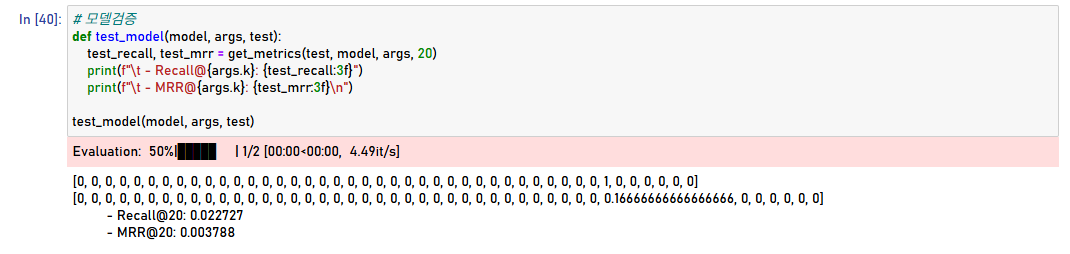

`args = Args(tr, val, test, batch_size=128, hsz=200, drop_rate=0.1, lr=0.0005, epochs=10, k=20)`    
도 아주 미세한 차이로 나아진것을 확인할 수 있다.
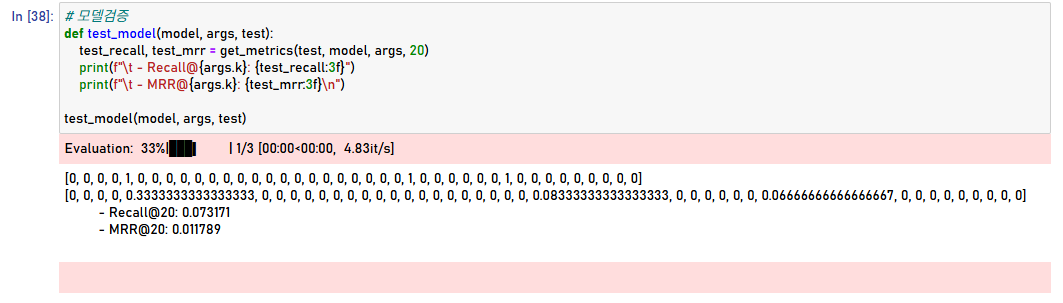

`args = Args(tr, val, test, batch_size=256, hsz=100, drop_rate=0.1, lr=0.001, epochs=5, k=20)`
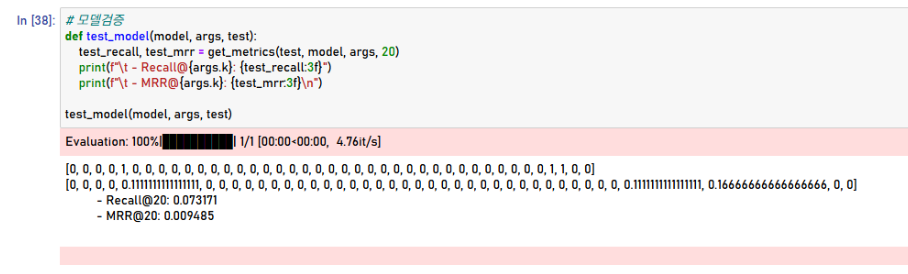

`args = Args(tr, val, test, batch_size=256, hsz=200, drop_rate=0.1, lr=0.0005, epochs=5, k=20)`
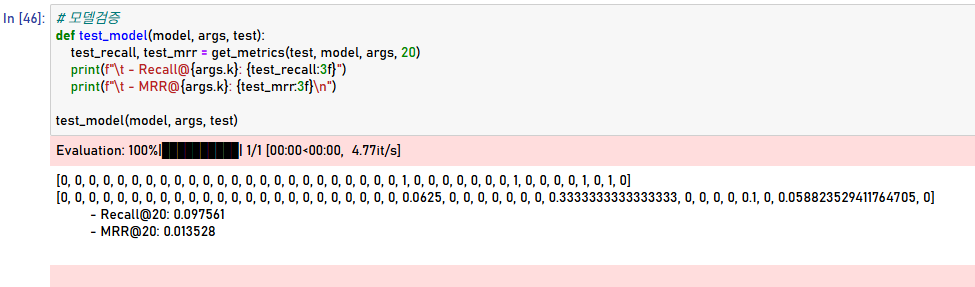